In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

## Polynomial basis function
$y=a_0 + a_1x + a_2x^2 + a_nx^n+\dots$

**Linear Regression Basics**:  
`LinearRegression` from scikit-learn fits a linear model to the data. The linear model assumes that the relationship between the input features (X) and the target variable (y) can be expressed as a linear combination of the input features:  
  
$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \dots + \beta_nx_n + \epsilon$
  
where:
- $\beta_0$ is the intercept.
- $\beta_1 , \beta_2 , \dots , \beta_n$ are the coefficients for each feature.
- $\epsilon$ is the error term.
  
*Handling non-linear data*: 
The key to understanding why `LinearRegression` can handle non-linear data when combined with transformations is to focus on the features it operates on, not the original data.
  
-> Example with `PolynomialFeature`:
1. Transforming Input Data:  
`PolynomialFeatures` creates new features by raising the original input features to different powers. If your orignial feature is $x$, and you set degree to 2, the transformed features will be $[1,x,x^2]$.
2. Fitting `LinearRegression`:  
`LinearRegression` then fits a linear model to these transformed features. Even though the model is still linear in terms of the features, it can capture non-linear relationships in the original data because the transformed features include non-linear terms (e.g. $x^2$).

In [2]:
# array with input parameters
x = np.array([2,3,4])

# calling class
poly_function = PolynomialFeatures(3, include_bias=False)
poly_function.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

The transformer converted the one-dimensional input array into a three-dimensional array by taking exponents of each value. So now we can plug it into our regression model.

In [7]:
# creating the polynomial model
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

# creating data
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

# example of a sine wave
xfit = np.linspace(0,10,100)
poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

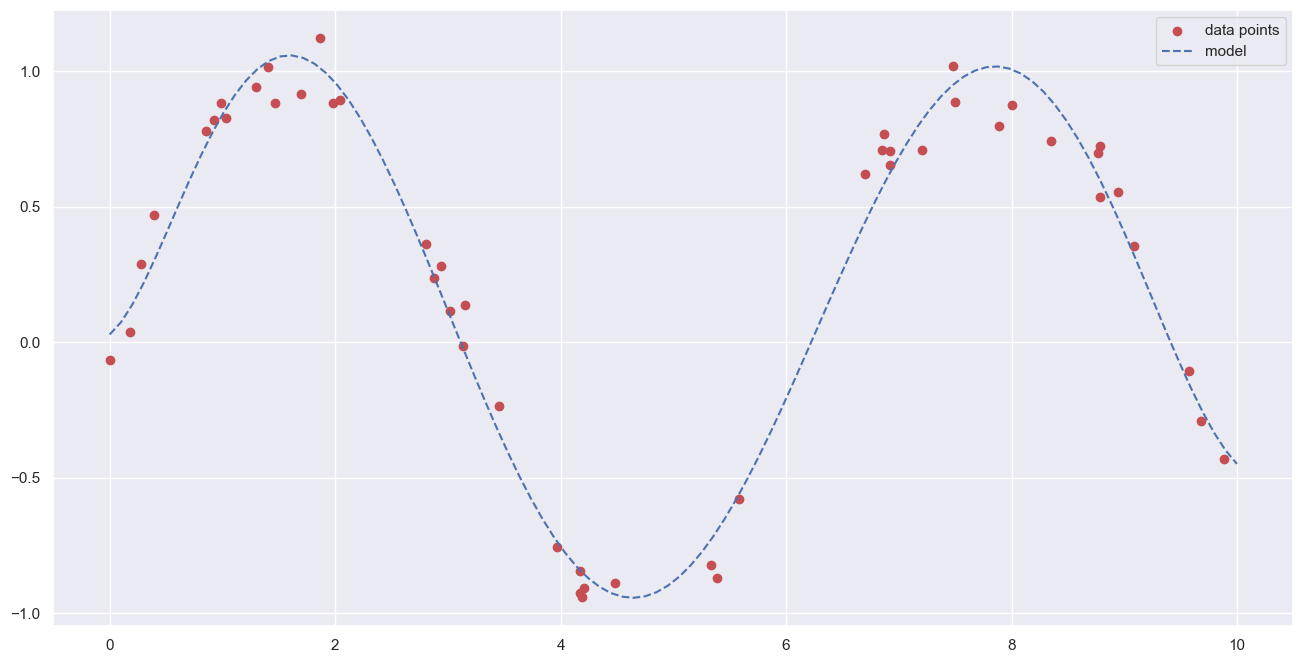

In [8]:
fig = plt.subplots(figsize=(16,8))
plt.scatter(x, y, color='r', label='data points')
plt.plot(xfit, yfit, 'b--', label='model')
plt.legend(loc='best');

The model of 7-th degree shows good capabilities in predicting the datapoints.

## Gaussian basis function

In [68]:
class GaussianFeatures(BaseEstimator, TransformerMixin):
    ''' Considerinf uniformly spaced Gaussian features for one-dimensional input'''
    def __init__(self, N, width_factor=2.):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # create N center spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)


In [69]:
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())

In [70]:
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

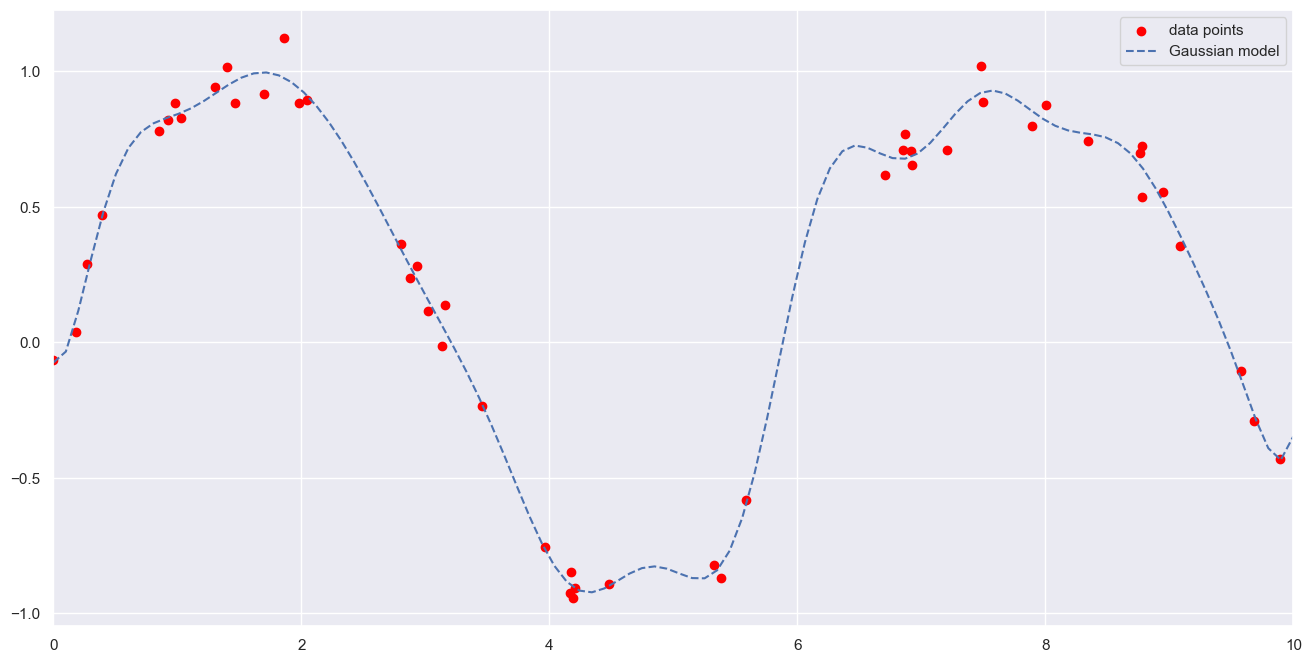

In [79]:
fig = plt.subplots(figsize=(16,8))
plt.scatter(x,y, color='red', label='data points')
plt.plot(xfit, yfit, 'b--', label='Gaussian model')
plt.xlim(0,10); plt.legend(loc='best');

## Regularization
**MAIN CONCEPT: Penalizing large values of the model parameters.**

In [72]:
features = 35
model = make_pipeline(GaussianFeatures(features),
                      LinearRegression())

model.fit(x[:, np.newaxis], y)

Pipeline(steps=[('gaussianfeatures', GaussianFeatures(N=35)),
                ('linearregression', LinearRegression())])

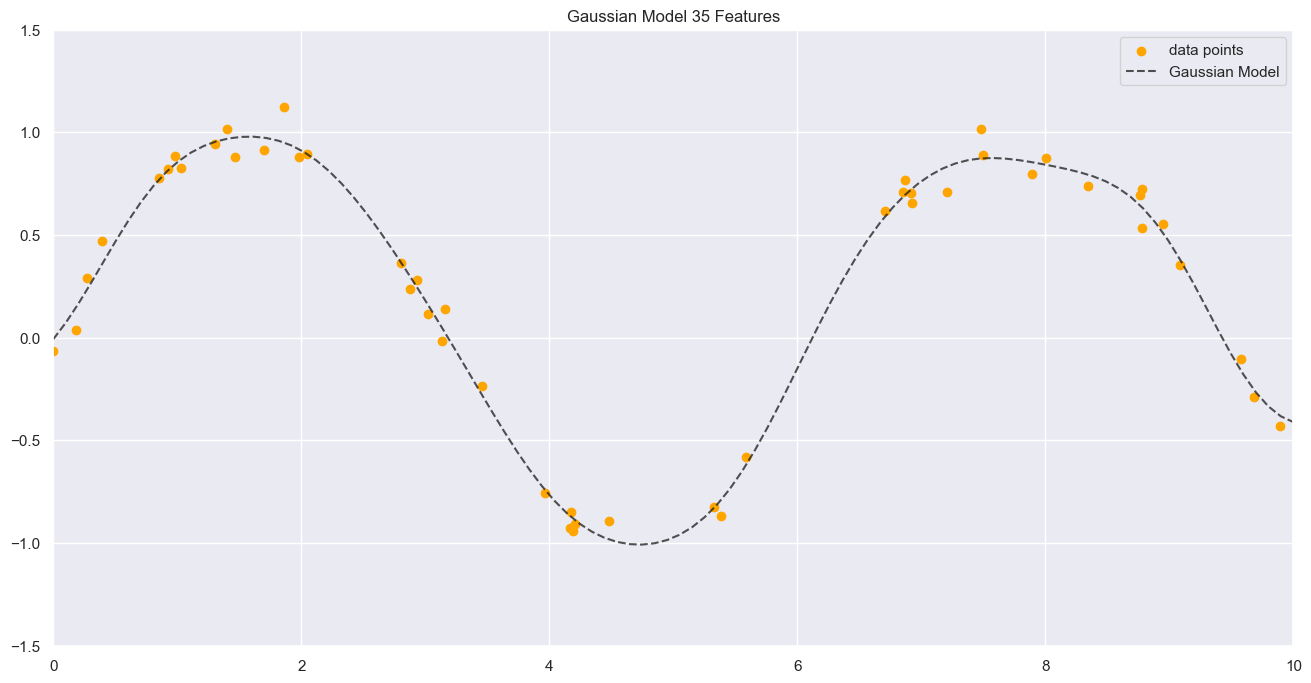

In [78]:
fig = plt.subplots(figsize=(16,8))
plt.scatter(x, y, color='orange', label='data points')
plt.plot(xfit, model.predict(xfit[:, np.newaxis]), 'k--', alpha=0.75, label='Gaussian Model')
plt.xlim(0,10);plt.ylim(-1.5, 1.5); plt.legend(loc='best'); plt.title(f'Gaussian Model {features} Features');

In [74]:
def comparison_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True, figsize=(16,8))
    model.fit(x[:, np.newaxis], y)

    # plotting
    ax[0].scatter(x, y, color='orange', label='Data points')
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]), 'k--', label='Gaussian Model')
    ax[0].legend(loc='best')
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5,1.5))

    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_,
               'k--',
               label='Gaussian Model')
    ax[1].legend(loc='best')
    
    ax[1].set(xlabel='Epochs', 
              ylabel='Coefficient',
              xlim=(0,10))
    

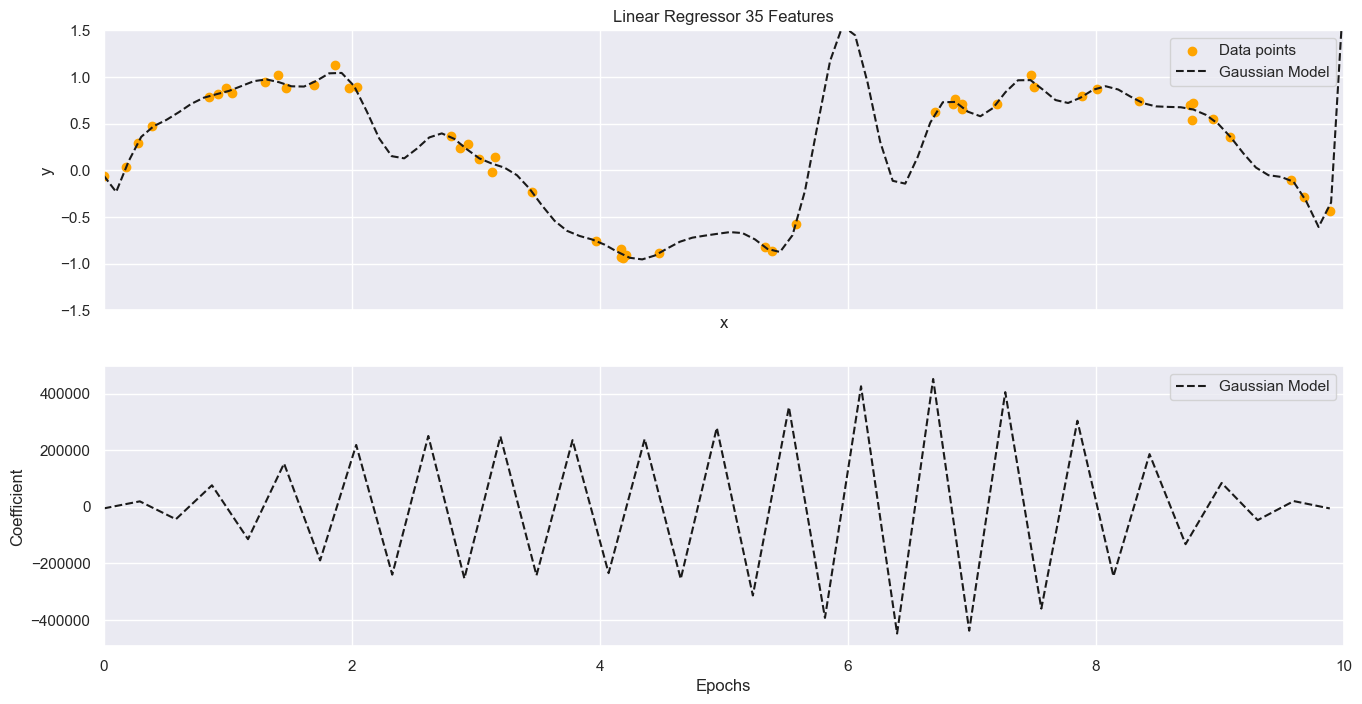

In [75]:
model = make_pipeline(GaussianFeatures(features),
                      LinearRegression())
comparison_plot(model, f'Linear Regressor {features} Features')

With 40 features, the model has too much flexibility and reaches extreme values in regions with no data (*classic overfitting*)

## Ridge Regression ($L_2$ Regularization)
- Sometimes called Tikhonov regularization
- Proceeds by penalizing the sum of squares (2-norms) of the model coefficients  
  
$$P=\alpha \sum_{n=1}^n \; \theta^2_n$$
$\alpha$ is a free parameter that weights the penaltym in Scikit-Learn is built into `Ridge estimator`

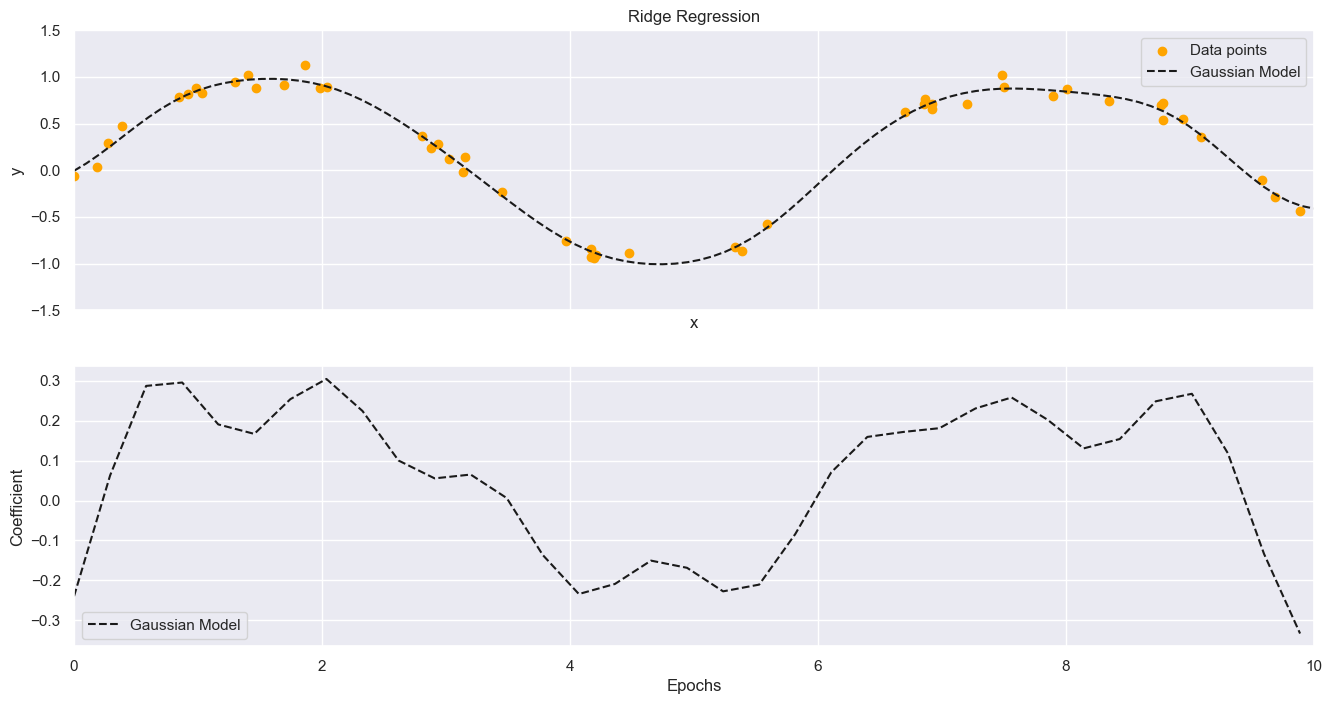

In [77]:
model = make_pipeline(GaussianFeatures(features),
                      Ridge(alpha=0.1))
comparison_plot(model, title='Ridge Regression')

The $\alpha$ parameter is a knob controlling the complexity of the resulting model.
- $\alpha \rightarrow 0$: recover the standard linear regression result
- $\alpha \rightarrow \infty$: models response will be surpressed

## Lasso Regression ($L_1$ Regularization)
**MAIN CONCEPT: Penalizing the sum of absolute values (1-norms) of regression coefficients**
  
$$P= \alpha \sum_{n=1}^N |\theta_n|$$
  
- Due to geometric reasons, the Lasso regression tends to favor *sparse* models when possible
- In other words: sets model coefficients to exctly zero

In [104]:
model = make_pipeline(GaussianFeatures(30),
                      Lasso(alpha=1e-3))

c:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-03, tolerance: 2.065e-03
  model = cd_fast.enet_coordinate_descent(


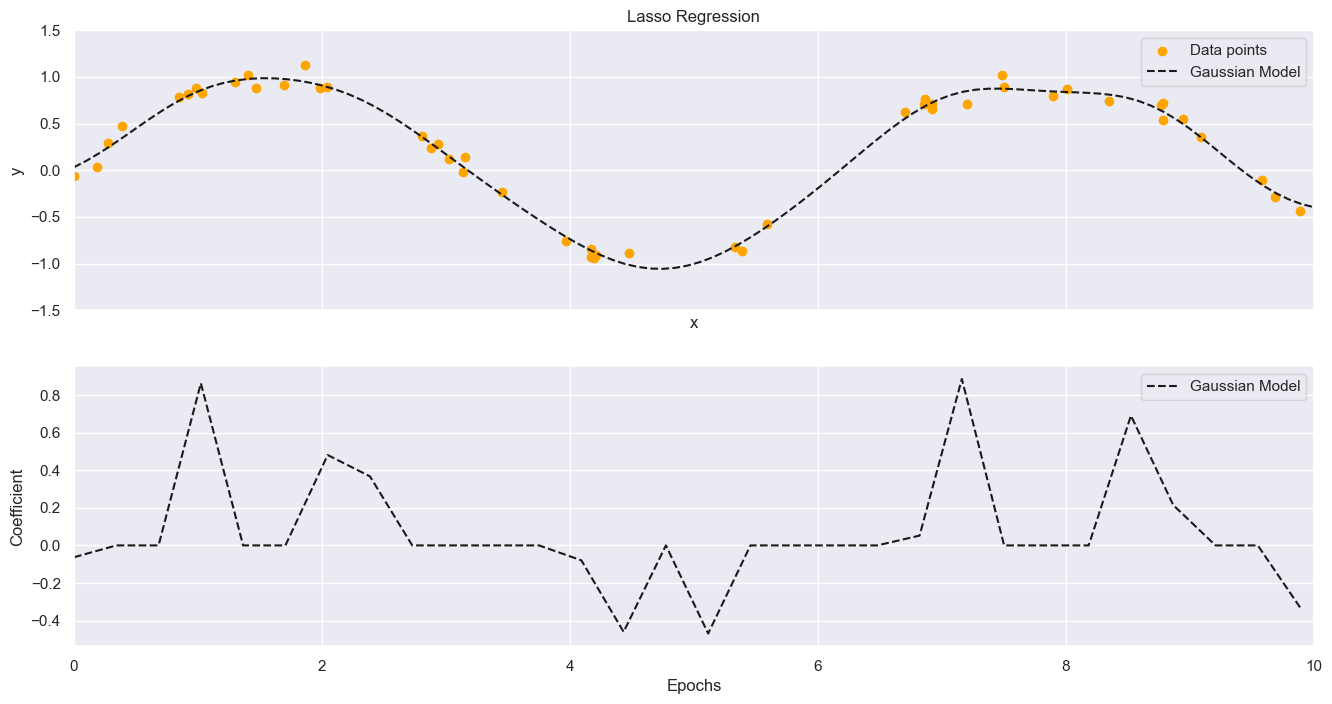

In [105]:
comparison_plot(model, title='Lasso Regression')

- The majority of the coefficients are exactly zero
- $\alpha$ parameter tunes the strength of the model and should be determined via, for example, cross-validation

When using `PolynomialFeatures` from scikit-learn, it is commonly paired with `LinearRegression`, but it can also be used with other types of models to capture non-linear relationships in the data. Here are some of the most common features and models that can be used with `PolynomialFeatures`:
  
1. Ridge Regression (`Ridge`):  
    * Adds L2 regularization to Linear Regression, which can help prevent overfitting, especially when working with high-degree polynomials.
    
2. Lasso Regression (`Lasso`):
    * Adds L1 regularization, which can help with feature selection by shrinking some coefficients to zero.
  
3. ElasticNet:
    * Combines L1 and L2 regularization, providing a balance between Ridge and Lasso regression.
  
4. Decision Trees (`DecisionTreeRegressor`/`DecicionTreeClassifier`):
    * Captures non-linear relationships and interactions between features without explicitly generating polynomial features.
  
5. Support Vector Machines (`SVR`/`SVC`):
    * Can be used with a polynomial kernel to capture non-linear relationships.